## Simulation for Multivariate Normal Distribution Search with a New Preference Function

This exploration notebook run a simulation to explore points in a multivariate normal distribution space for a given seed and psi0 values for the new preference function. It will also check the following conditions:

- "Condition 1": repeat point's outcome is the closest to 0
- "Condition 3": at each iteration, novel point has x or y that coincides with x-grid or y-grid in search history

### Running the Simulation:

All helper functions including the new preference function are in `colab_utils.py` script.


- **Pick a seed value**: 0 to 999 and run the cells to compute the simulation search path below.

  The cells will run and plot the simulation path for the chosen seed.

- Change the staple value for `psi0` to see the plots for different values of the variable.

  To change the `psi0` value, change the line of code with `staple = [-2, 0.5, 0.25, 1]`  to be: `staple = [-5, 0.5, 0.25, 1]` or `staple = [-10, 0.5, 0.25, 1]` as `staple` list contains the parameters for the simulation `[psi0, mu1, mu2, sigma0^2]`.

---
- Author: Natalya Rapstine
- Modified: Feb. 23, 2024


In [2]:
from google.colab import drive
# have to mount G drive to access and plot the results
drive.mount('/content/drive')
import os, sys
proj_folder = f'/content/drive/Shared drives/DARC -- Faculty Projects/Delivered Results/sjc/search_algo_code_development/new_preference_function'
# to import custom utility py script
sys.path.append(f'{proj_folder}')
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import sympy as sp
from colab_utils import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# change working directory to be the folder with this notebook
os.chdir(f'{proj_folder}')

In [4]:
# SET THE SEED NUBMER
# SET THE PSI0 VALUE
# to plot the search results for chosen seed and psi0

seed_num = 777

# Parameters for Brownian staple : [psi0, mu1, mu2, sigma0^2]
staple = [-2, 0.5, 0.25, 1]

# uncomment below to set psi0 to a different value
# staple = [-5, 0.5, 0.25, 1]
# staple = [-10, 0.5, 0.25, 1]

Starting simulation for 0777 seed...
i: 0
i: 1
i: 2
repeat_point: (2.000000000000003, 0.0)


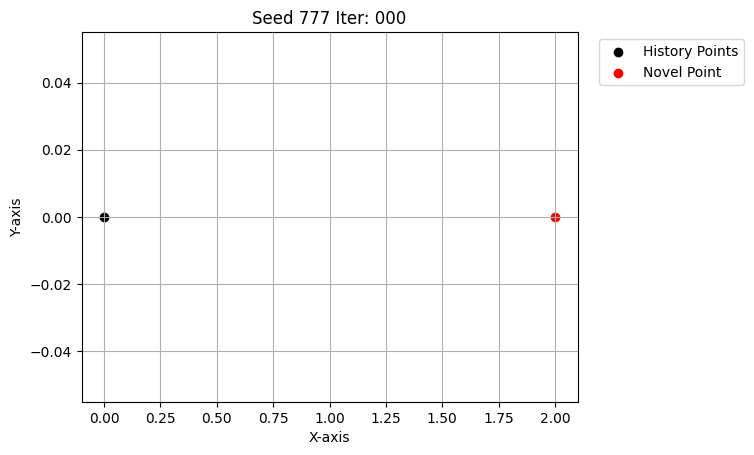

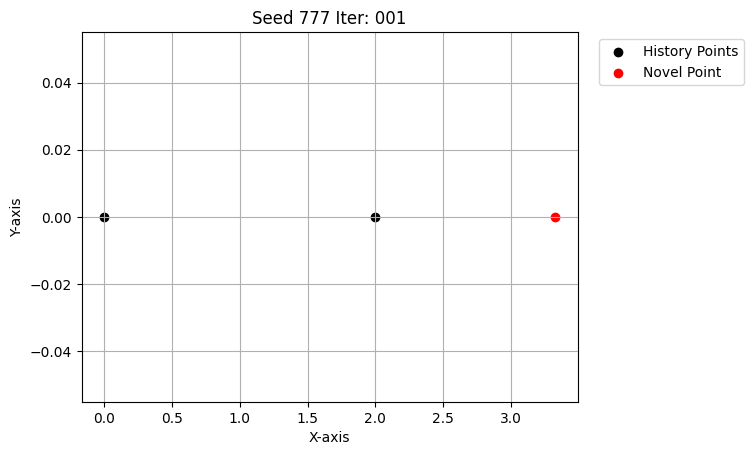

In [5]:
np.random.seed(seed_num)

repeat_point = None

print(f"Starting simulation for {seed_num:04} seed...")
# lists to store histories and outcome
history, novelhistory, outcome, derivative_history = [], [], [], []

# x, y grids
xgrid = [0]
ygrid = [0]

# error tolerance
eps = 10 ** (-4)

# max iter number
maxiter = 500

cond_three = []

for i in range(maxiter):
    print(f"i: {i}")
    # fix the inverse of var - covar matrix first
    ivm = np.linalg.inv(var_mat(history, staple))

    min_x = min(xgrid)
    min_y = min(ygrid)
    max_x = max(xgrid)
    max_y = max(ygrid)

    if min_x == max_x:
        max_x = min_x + 1
    else:
        max_x += 1

    if min_y == max_y:
        max_y = min_y + 1
    else:
        max_y += 1

    # run optimization 100 times with different initial points and choose the optima
    initial_points = generate_initial_points(startx=min_x, endx=max_x, starty=min_y, endy=max_y)
    novelpoint = find_global_minima(history, outcome, staple, preference_func, ivm, initial_points)[1]
    novelpoint = adjust_round_error(novelpoint, xgrid, ygrid, eps)

    # check if novelpoint is already in history
    if novelpoint in history + [(0, 0)]:
        repeat_point = novelpoint
        print(f"repeat_point: {repeat_point}")
        break

    else:
        novelhistory.append(novelpoint)
        xgrid, ygrid = append_grid(novelpoint, xgrid, ygrid)

        # Check for CONDITION 3: at each iter, novel point has x or y that coincides with x-grid or y-grid in history
        # Extracting x's and y's
        grid_history_x = set( [p[0] for p in history + [(0, 0)]] )
        grid_history_y = set( [p[1] for p in history + [(0, 0)]])

        # check that the novel point's x-entry or its y-entry coincides with that of a point already in the history:
        # novelpoint's x or y must be in the grid history x or y sets
        if (novelpoint[0] in grid_history_x) or (novelpoint[1] in grid_history_y):
            cond_three.append(True)
        else:
            cond_three.append(False)

        searchpoints = new_search_points(novelpoint, history, xgrid, ygrid)
        newoutcome = simulate(searchpoints, history, outcome, staple, ivm)
        outcome.extend(newoutcome)
        derivative_points = [p for p in searchpoints if p not in set(history + [novelpoint])]

        # Uncomment to make plots of the search path
        # plot_current_state(novelpoint, history, derivative_points, i, seed_num, f'one-seed-run')

        # plots the current iteration of the search process

        plot_current_iter(novelpoint, history, derivative_points, i, seed_num)

        history.extend(searchpoints)
        if derivative_points:
            derivative_history.extend(derivative_points)

In [6]:
# there is a repeat point, so now we check CONDITION 1 and CONDITION 3
# Find the minimum absolute difference from 0 for all points outcomes
abs_differences = [abs(o - 0.0) for o in outcome]
# Find min difference
min_difference = min(abs_differences)
# print(f"min_difference: {min_difference}")

# Find outcome at repeat point
if repeat_point != (0.0, 0.0):
    repeat_point_index = history.index(repeat_point)
    # print(f"repeat_point_index: {repeat_point_index}")
    repeat_point_outcome = outcome[repeat_point_index]
    # print(f"repeat_point_outcome: {repeat_point_outcome}")

    # Calculate the absolute difference of the repeat point's outcome from 0
    repeat_point_abs_difference = abs(repeat_point_outcome - 0.0)

    # Check if the repeat point's outcome is the closest to 0
    if repeat_point_abs_difference == min_difference:
        # print("The repeat point's outcome is the closest to 0 among all outcomes.")
        print("CONDITION 1 PASSED: repeat point's outcome is the closest to 0")
        cond_one = True
    else:
        print("CONDITION 1 FAILED! There is another point with an outcome closer to 0 than the repeat point's outcome.")
        cond_one = False
else:
    # if repeat point is (0, 0), outcome is 0
    print(f"repeat_point: {repeat_point}")
    print("CONDITION 1 PASSED: repeat point's outcome is the closest to 0")
    cond_one = True

if ( sum(cond_three) != len(novelhistory) ):
    print("CONDITION 3 FAILED!")
else:
  print("CONDITION 3 PASSED: at each iter, novel point has x or y that coincides with x-grid or y-grid in history")

CONDITION 1 PASSED: repeat point's outcome is the closest to 0
CONDITION 3 PASSED: at each iter, novel point has x or y that coincides with x-grid or y-grid in history
